# ChainLink Price Prediction 2021

## 1. Data Preparation

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report,accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Input
from keras.models import Sequential,Model

In [132]:
df = pd.read_csv('data/coin_Litecoin.csv')

#spliting 'Date' column to 'date' and 'time'
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].dt.date
df['time'] = df['Date'].dt.time

#drop non-relevant columns
df.drop(['SNo','Name','Symbol','Date','time'], axis=1, inplace=True,errors='ignore')
#set date as new index
df.set_index('date',inplace=True)

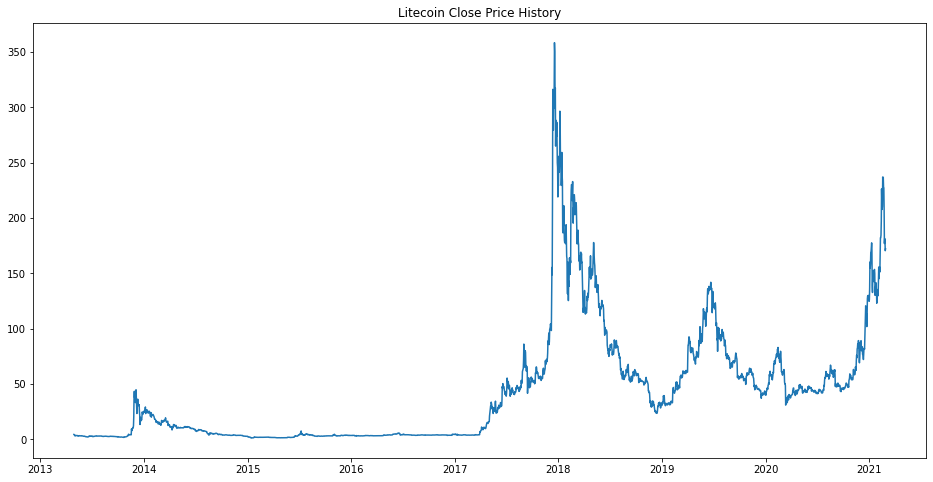

In [134]:
plt.figure(figsize=(16,8))
plt.title('Litecoin Close Price History')
plt.plot(df['Close'])

# Using 1 input for LSTM model

## 2.Data Preprocessing

In [118]:
df = df.loc[pd.to_datetime(df.index) > pd.to_datetime('2017-06-01'),:]

In [119]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [120]:
#Create a new dataframe with only close column
#data = df.filter(['Close'])
#convert to a numpy array
#dataset = data.values

#get the number of rows to train the model on
#train_idx = math.ceil(len(dataset) * .8)

#train_idx

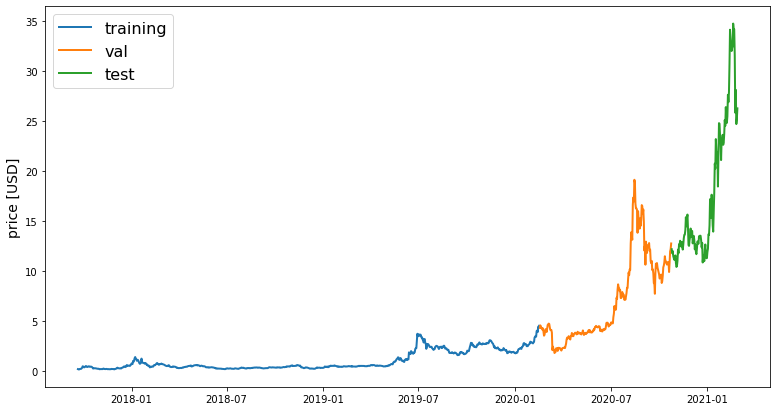

In [121]:
def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot3(line1, line2,line3, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot3(line1 = train_df.filter(['Close']), 
          line2 = val_df.filter(['Close']),
          line3 = test_df.filter(['Close']), label1='training',label2='val',label3= 'test', title='')

### 2.1 Data Normalization

In [18]:
def scale_func(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = scaler.transform(val_df)
scaled_test_df = scaler.transform(test_df)

In [14]:
#create the training data set
def generate_input(df, window):
    #create the scaled training data set
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df[i-window:i, 0])
        y_train.append(df[i,0])
    return x_train, y_train

In [107]:
x_train, y_train = generate_input(scaled_data,15)
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train), np.array(x_val)
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#reshape the data
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

print("Training set:",x_train.shape)
print("Validation set:",x_val.shape)

In [115]:
def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = input_shape))
    model.add(LSTM(50, return_sequences=False, dropout=0.5, recurrent_dropout=0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_class_build(input_shape):
    #build the lstm model
    model = Sequential()
    #### Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    #### Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    #### Adding the output layer
    model.add(Dense(units = 1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def accuracy_forecast(target_val ,prediction_val):   
    bi_targ = np.sign(target_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    bi_pred = np.sign(prediction_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    return accuracy_score(bi_targ,bi_pred)

In [116]:
model = model_class_build(input_shape= (x_train.shape[1],x_train.shape[2]))

In [117]:
#train the model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
34/34 [==============================] - 7s 23ms/step - loss: 0.0258
Epoch 2/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0056
Epoch 3/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0052
Epoch 4/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0048
Epoch 5/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0048
Epoch 6/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0043
Epoch 7/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0034
Epoch 8/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0040
Epoch 9/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0029
Epoch 10/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0034
Epoch 11/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0032
Epoch 12/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0027
Epoch 13/100
34/34 [=====

In [118]:
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = scaler.inverse_transform(predictions)

#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - val_data[60:]) ** 2)

print("RMSE:",rmse)
print("Accuracy:",accuracy_forecast(valid.Close, valid.Predictions))

RMSE: 80.27264693243728
Accuracy: 0.4522058823529412


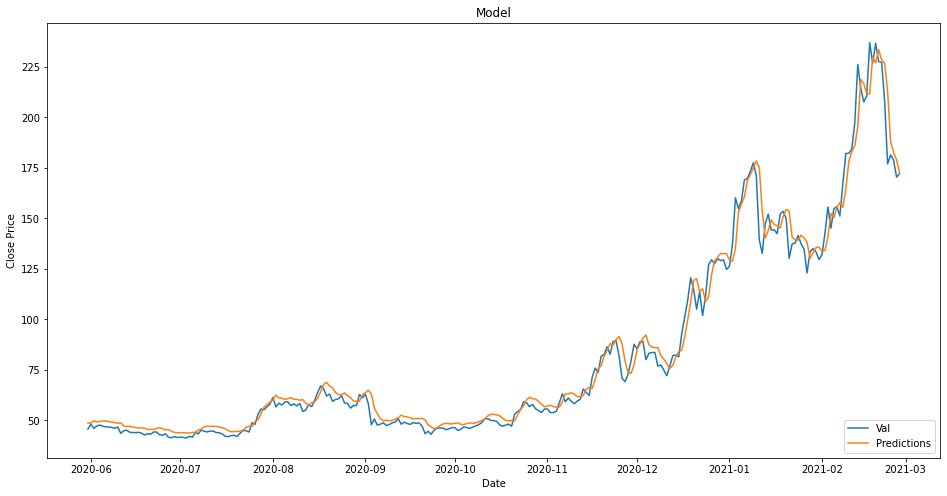

In [102]:
#plot the data
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [ ]:
X_test

In [105]:
LINK_quote = web.DataReader('LTC-USD', data_source='yahoo', start='2017-09-21', end='2021-03-10')
#create a new dataframe
new_df = LINK_quote.filter(['Close'])
#Get the last 60 day closing price
last_60_days = new_df[-15:].values
#scale the data
last_60_days_scale = scaler.transform(last_60_days)
#create an empty list
X_test = []
X_test.append(last_60_days_scale)
#convert the x_test to np.array
X_test = np.array(X_test)
#reshape
X_test = np.reshape(X_test, ((X_test.shape[0], X_test.shape[1], 1)))
#get predicted price
pred_price = model.predict(X_test)
#undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[202.13531]]


In [106]:
LINK_quote2 = web.DataReader('LTC-USD', data_source='yahoo', start='2021-03-11', end='2021-03-11')
print(LINK_quote2)

                  High         Low        Open       Close      Volume  \
Date                                                                     
2021-03-11  203.167831  191.536835  200.449753  201.250336  4823154653   
2021-03-12  223.614975  198.953842  201.273666  220.829407  8079722567   

             Adj Close  
Date                    
2021-03-11  201.250336  
2021-03-12  220.829407  


## Multiple input with normal features

In [122]:
df

High        Low       Open      Close        Volume  \
date                                                                   
2017-09-21   0.207892   0.155292   0.189132   0.169680  2.126270e+06   
2017-09-22   0.181675   0.139869   0.169826   0.150503  1.423220e+06   
2017-09-23   0.157440   0.126297   0.149562   0.131129  1.186670e+06   
2017-09-24   0.190250   0.130275   0.131110   0.170278  1.025740e+06   
2017-09-25   0.182637   0.158580   0.170636   0.182198  1.021370e+06   
...               ...        ...        ...        ...           ...   
2021-02-23  31.549831  21.198072  31.522873  25.800343  5.101236e+09   
2021-02-24  29.178788  24.645512  25.827651  28.086719  3.087990e+09   
2021-02-25  28.556830  24.595960  28.073373  24.668047  2.016769e+09   
2021-02-26  26.948970  23.761681  24.734231  25.187313  1.705493e+11   
2021-02-27  27.390610  24.906771  25.197746  26.235097  1.874411e+09   

               Marketcap  
date                      
2017-09-21  5.938800e+07  
2017-09-22  5.267605e+07  
2017-09-23  4.589515e+07  
2017-09-24  5.959730e+07  
2017-09-25  6.376930e+07  
...                  ...  
2021-02-23  1.053969e+10  
2021-02-24  1.147369e+10  
2021-02-25  1.007713e+10  
2021-02-26  1.032704e+10  
2021-02-27  1.075664e+10  

[1256 rows x 6 columns]

In [123]:
# Feature Engineering
#day_diff = df['Close'] - df['Open']
#df['rel_close'] = day_diff / df['Open']
#df['high_low_ratio'] = df['High'] / df['Low']
#df['rel_high'] = df['High'] / df['Close']
#df['rel_low'] = df['Low'] / df['Close']


In [124]:
scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = pd.DataFrame(scaler.transform(val_df), index=val_df.index,columns=val_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index,columns=test_df.columns)

In [125]:
df["Close"].copy()

date
2017-09-21     0.169680
2017-09-22     0.150503
2017-09-23     0.131129
2017-09-24     0.170278
2017-09-25     0.182198
                ...    
2021-02-23    25.800343
2021-02-24    28.086719
2021-02-25    24.668047
2021-02-26    25.187313
2021-02-27    26.235097
Name: Close, Length: 1256, dtype: float64

In [126]:
scaled_train_df

High       Low      Open     Close    Volume  Marketcap
date                                                                   
2017-09-21 -0.841380 -0.865235 -0.845851 -0.865106 -0.527670  -0.865104
2017-09-22 -0.868014 -0.882299 -0.866402 -0.885366 -0.536678  -0.885364
2017-09-23 -0.892635 -0.897314 -0.887972 -0.905835 -0.539709  -0.905832
2017-09-24 -0.859303 -0.892913 -0.907613 -0.864474 -0.541770  -0.864472
2017-09-25 -0.867037 -0.861598 -0.865539 -0.851881 -0.541826  -0.851879
...              ...       ...       ...       ...       ...        ...
2020-02-12  3.208571  3.242932  3.184248  3.208096  5.276238   3.208095
2020-02-13  3.104076  3.131861  3.229052  3.048900  3.750743   3.048900
2020-02-14  3.491281  3.179096  3.077704  3.619336  4.785349   3.619335
2020-02-15  3.628101  3.511611  3.651727  3.503427  5.831474   3.503425
2020-02-16  3.855253  3.549537  3.542790  3.714206  7.655385   3.714205

[879 rows x 6 columns]

In [127]:
def input_generator(df, target, window):
    feature_cols = df.columns  
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i,:])
        y_train.append(df.iloc[i,:][target])
    #convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train,y_train

x_train, y_train = input_generator(scaled_train_df, "Close", 5)
x_val, y_val = input_generator(scaled_val_df, "Close", 5)
x_test, y_test = input_generator(scaled_test_df, "Close", 5)
#coin_history, x_cols = create_history_frames(coin_dataframes)

In [128]:
#build the lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1))
model.add(Activation('linear'))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [131]:
#train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True, batch_size=16, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 22.9602
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 23.0725
Epoch 3/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0110 - val_loss: 22.9208
Epoch 4/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0106 - val_loss: 22.7067
Epoch 5/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0110 - val_loss: 22.7364
Epoch 6/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0107 - val_loss: 22.9031
Epoch 7/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0103 - val_loss: 22.7223
Epoch 8/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0105 - val_loss: 22.8430
Epoch 9/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0105 - val_loss: 23.1783
Epoch 10/100
54/55 [============================>.] - ETA: 0s - loss: 0.0103

KeyboardInterrupt: 

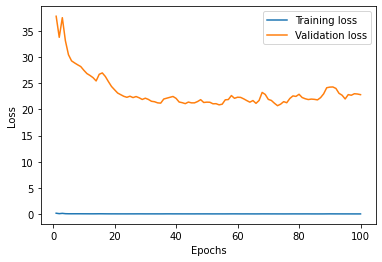

In [130]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],label="Training loss")
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
target_scaler = StandardScaler()
target_scaler.fit(train_df[['Close']])
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = target_scaler.inverse_transform(predictions)

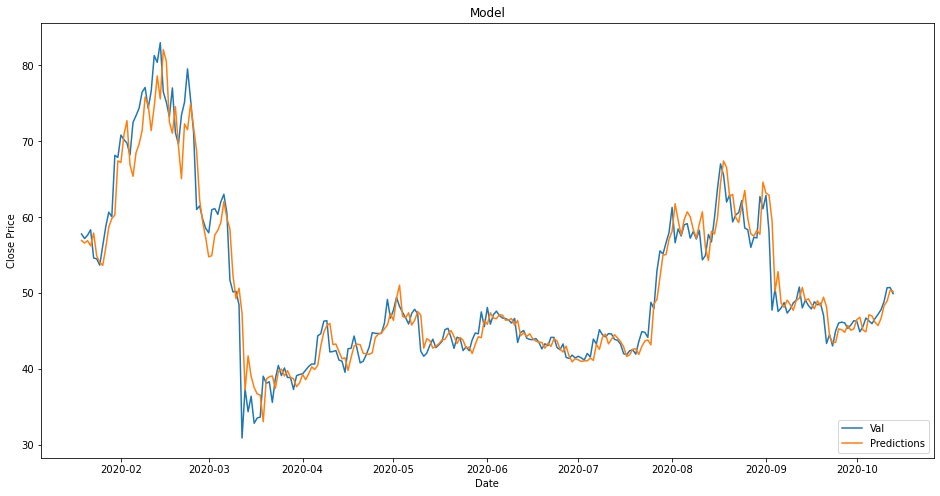

In [97]:
#plot the data
valid = val_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [99]:
mean_absolute_error(valid['Close'], valid['Predictions'])

1.7669161354469112

### Test data

In [101]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

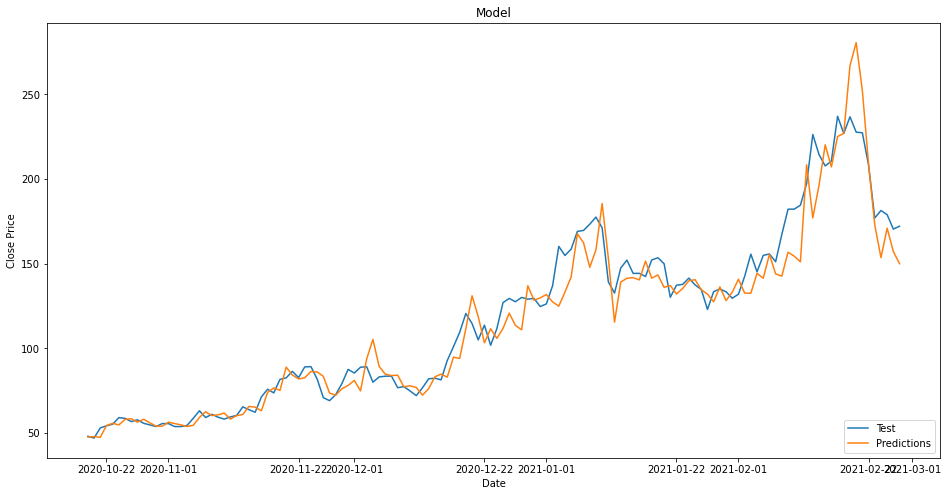

In [102]:
#plot the data
valid = test_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Test','Predictions'], loc='lower right')
plt.show()

In [103]:
mean_absolute_error(valid['Close'], valid['Predictions'])

8.67079165147202

# Bidirectional

In [106]:
#build the lstm model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2]))))
model.add(Bidirectional(LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1))
model.add(Activation('linear'))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
#train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=False,batch_size=16, epochs=100)

Epoch 1/100
60/60 [==============================] - 34s 72ms/step - loss: 0.5155 - val_loss: 0.0671
Epoch 2/100
60/60 [==============================] - 1s 13ms/step - loss: 0.1776 - val_loss: 0.0054
Epoch 3/100
60/60 [==============================] - 1s 15ms/step - loss: 0.2099 - val_loss: 0.0641
Epoch 4/100
60/60 [==============================] - 1s 13ms/step - loss: 0.1193 - val_loss: 0.0052
Epoch 5/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0681 - val_loss: 0.0064
Epoch 6/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0599 - val_loss: 0.0088
Epoch 7/100
60/60 [==============================] - 1s 15ms/step - loss: 0.0811 - val_loss: 0.0121
Epoch 8/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0656 - val_loss: 0.0077
Epoch 9/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0563 - val_loss: 0.0083
Epoch 10/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0500 - val_loss: 0.005

60/60 [==============================] - 1s 15ms/step - loss: 0.0397 - val_loss: 0.0131
Epoch 83/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0540 - val_loss: 0.0044
Epoch 84/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0320 - val_loss: 0.0137
Epoch 85/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0356 - val_loss: 0.0113
Epoch 86/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0498 - val_loss: 0.0042
Epoch 87/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0421 - val_loss: 0.0213
Epoch 88/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0545 - val_loss: 0.0049
Epoch 89/100
60/60 [==============================] - 1s 15ms/step - loss: 0.0326 - val_loss: 0.0126
Epoch 90/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0418 - val_loss: 0.0134
Epoch 91/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0675 - val_loss: 0.0043
Epo

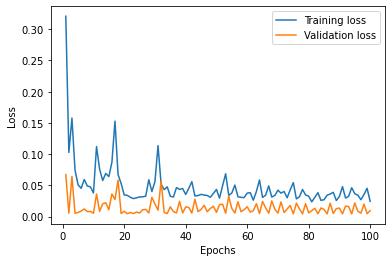

In [108]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],label="Training loss")
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
target_scaler = StandardScaler()
target_scaler.fit(train_df[['Close']])
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = target_scaler.inverse_transform(predictions)

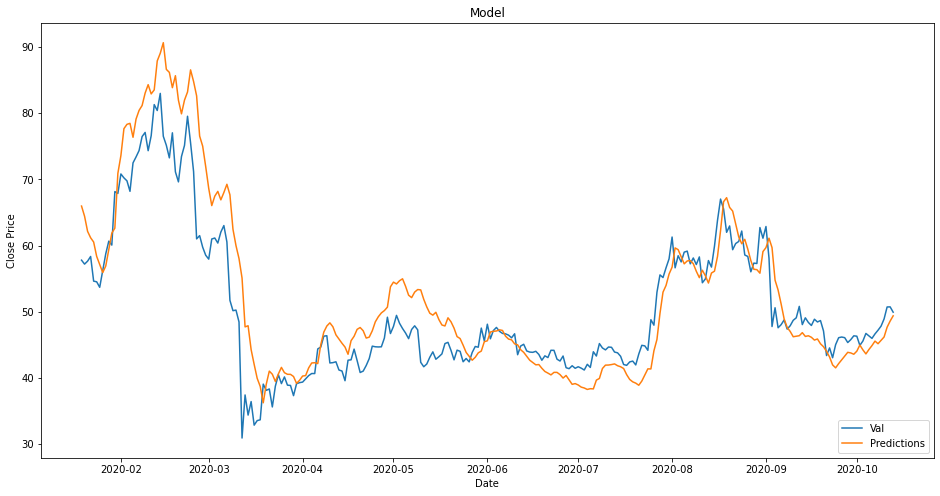

In [111]:
#plot the data
valid = val_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [112]:
mean_absolute_error(valid['Close'], valid['Predictions'])

4.050404185172386

### Test data

In [113]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

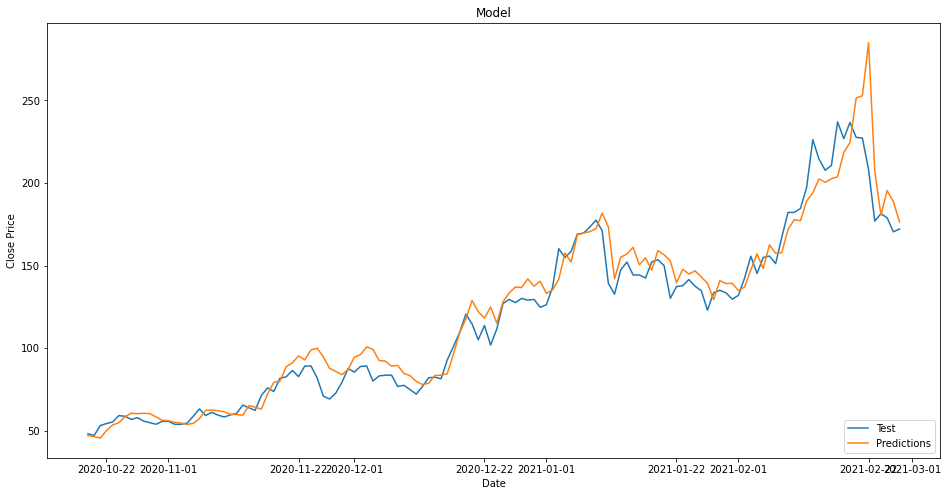

In [114]:
#plot the data
valid = test_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Test','Predictions'], loc='lower right')
plt.show()

In [115]:
mean_absolute_error(valid['Close'], valid['Predictions'])

8.477366795583865